In [1]:
import sys
import math
import numpy as np
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nLenslet = 1
n = 401
nPx = n*nLenslet+1
D = 25.5
n_radius = nPx
#onAxis = ceo.Source("R",zenith=0.*math.pi/180/3600,azimuth=0*math.pi/4,
#                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])
src    = ceo.Source("J",zenith=np.array([8])*ceo.constants.ARCMIN2RAD,
                    azimuth=np.array([0])*math.pi/180,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
GMT = ceo.GMT_MX(D,nPx)
wfs = ceo.ShackHartmann(1,nPx-1,D,N_PX_IMAGE=nPx)

In [3]:
GMT.M1.motion_CS.origin[0,2] = -1e-6
GMT.M1.motion_CS.origin[3,2] = -1e-6
GMT.M1.motion_CS.origin[1,2] = 0.5e-6
GMT.M1.motion_CS.origin[5,2] = -0.5e-6
GMT.M1.motion_CS.origin[4,2] = 0.5e-6
GMT.M1.motion_CS.origin[2,2] = -0.5e-6
GMT.M1.motion_CS.origin[6,2] = 1e-6
GMT.M1.motion_CS.update()

In [4]:
GMT.propagate(src)

In [5]:
sps = ceo.SegmentPistonSensor(GMT.M1,src)

In [6]:
src.nBackgroundPhoton(1)
sps.propagate(src)

In [7]:
src.magnitude = [0]
sps.camera.reset()
sps.propagate(src)
#sps.readOut(1e-2,0)
sps.camera.readOut(1e-2,0,1000000)
#sps.readOut(1e-2,0,0)
#c = sps.camera
#c.nBackgroundPhoton = 5186050
#+c
#sps.fft()

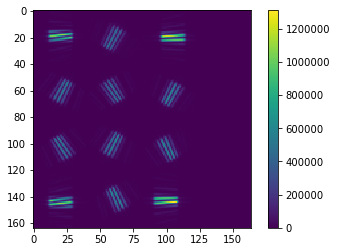

In [8]:
plt.imshow(sps.camera.frame.host())
plt.colorbar()

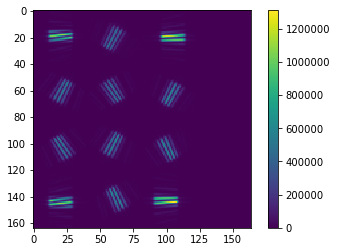

In [9]:
plt.imshow(sps.camera.frame.host())
plt.colorbar()

In [12]:
print("Expected # of background photons: %.0f"%(1000000*1e-2))
print("Measured # of background photons: %.0f"%(np.var(sps.camera.frame.host())*sps.camera.N_PX_FRAME**2))

Expected # of background photons: 10000
Measured # of background photons: 268097400094720


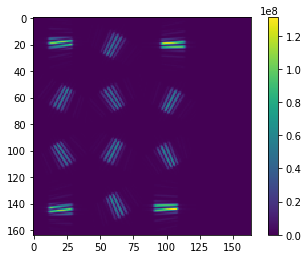

In [13]:
plt.imshow(sps.camera.ghost_frame)
plt.colorbar()

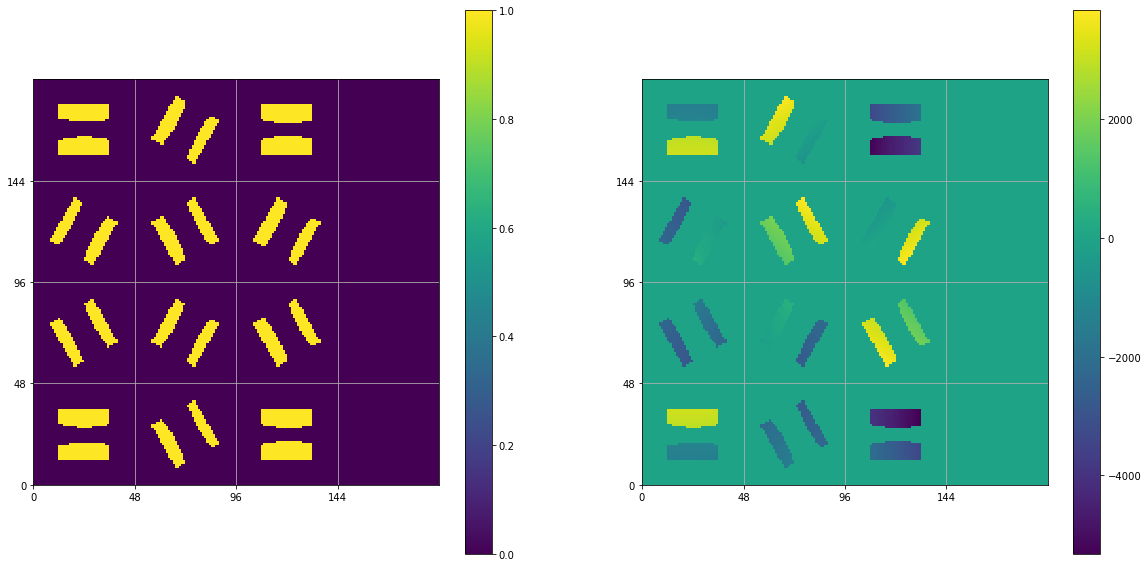

In [14]:
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches((20,10))
h1 = ax1.imshow(sps.W.amplitude.host(),
                interpolation='None',
                extent=[0,sps.W.amplitude.shape[0],0,sps.W.amplitude.shape[1]],
                origin='lower')
ticks = sps.W.amplitude.shape[1]/4
ax1.set_xticks(np.arange(0,ticks*4, ticks))
ax1.set_yticks(np.arange(0,ticks*4, ticks))
ax1.grid()
colorbar(h1,ax=ax1)
h2 = ax2.imshow(sps.W.phase.host(units='nm'),
               interpolation='None',
                extent=[0,sps.W.amplitude.shape[0],0,sps.W.amplitude.shape[1]],
               origin='lower')
ax2.set_xticks(np.arange(0,ticks*4, ticks))
ax2.set_yticks(np.arange(0,ticks*4, ticks))
ax2.grid()
colorbar(h2,ax=ax2)

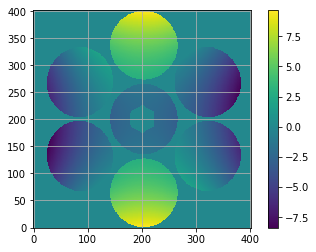

In [15]:
imshow(src.phase.host(units='micron'),interpolation='None',origin='lower')
grid()
colorbar()

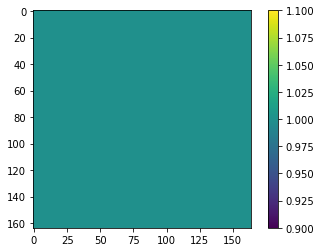

In [16]:
orig_mask = sps.fft_mask.f.host()
np.sqrt(orig_mask.shape)
plt.imshow(orig_mask.reshape(164,164))
plt.colorbar()

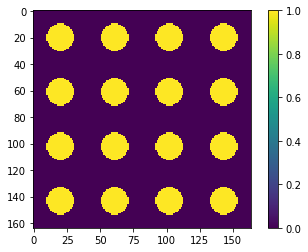

In [17]:
circ = ceo.Telescope(41,1,scale=0.5)
circ_m = circ.f.host(shape=(41,41))
big_circ_m = np.tile(np.tile(circ_m,4).T,4)
plt.imshow(big_circ_m)
colorbar()
gpu_big_circ_m = ceo.cuFloatArray(host_data=big_circ_m)
sps.fft_mask.alter(gpu_big_circ_m)

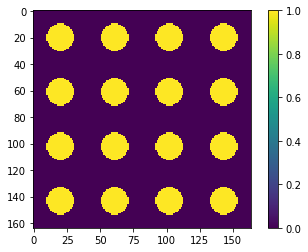

In [18]:
imshow(sps.fft_mask.f.host(shape=(164,164)))
colorbar()

In [19]:
src.magnitude = [10]
sps.camera.reset()
sps.propagate(src)
#sps.readOut(1e-2,1,16)
#sps.camera.readOut(1e-2,0,10)
sps.fft()

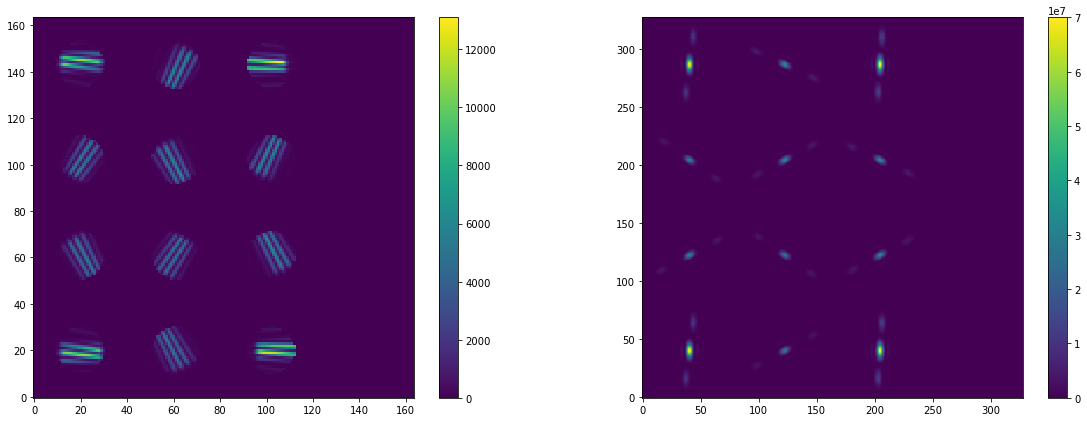

In [20]:
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches((20,7))
h1 = ax1.imshow(sps.camera.frame.host(),interpolation='None',origin='lower')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(sps.fftlet.host(),interpolation='None',origin='lower')
colorbar(h2,ax=ax2)

In [21]:
atm = ceo.GmtAtmosphere(0.15,30)

In [22]:
p = D/(nPx-1)
src.reset()
atm.get_phase_screen(src,  p, nPx, p, nPx, 0.0)

In [23]:
src.phase.shape

(402, 402)

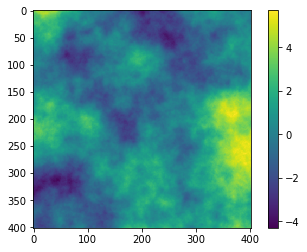

In [24]:
imshow(src.phase.host(units='micron').T,interpolation='None')
colorbar()

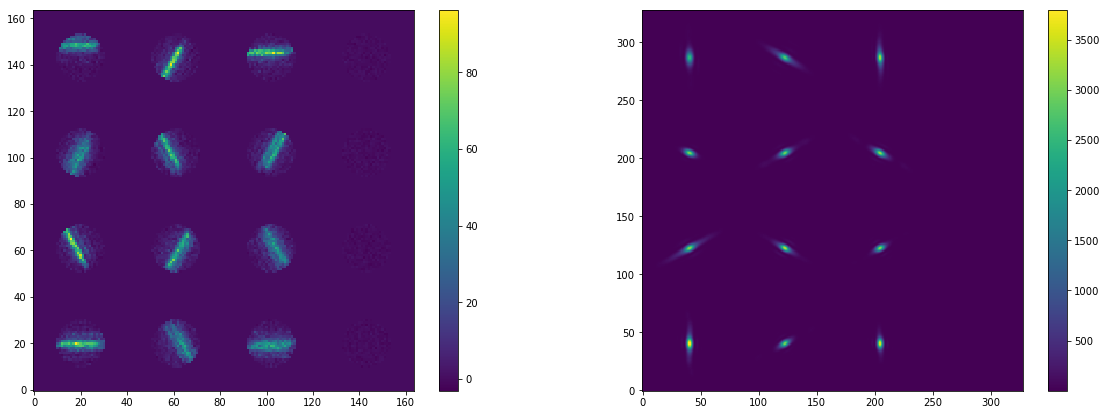

In [25]:
sps.camera.reset()
sps.propagate(src)
#sps.camera.readOut(1e-2,0)
sps.readOut(1e-2,1,16)
sps.fftlet.reset()
sps.fft()
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches((20,7))
h1 = ax1.imshow(sps.camera.frame.host(),interpolation='None',origin='lower')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(sps.fftlet.host(),interpolation='None',origin='lower')
colorbar(h2,ax=ax2)